# **XAI4Spectra**

# **Loading data**

In [1]:
# importing the necessary libraries
import pandas as pd
import numpy as np
import kennard_stone as ks

# loading a soil spectral dataset based on X-ray fluorescence (XRF)
#data_complete = pd.read_csv('https://raw.githubusercontent.com/joseviniciusr/XAI4Spectra/main/XRFspectra.csv', sep=';') # Toledo 2022 dataset
data_complete = pd.read_csv('XRFspectra.csv', sep=';') # local copy of Toledo 2022 dataset
data = data_complete.loc[:, '1':'15']
data.insert(0, 'exCa', data_complete['exCa'])  # inserting the target variable (e.g., exCa (exchangeable calcium))

## **PLS- (R or DA) modeling**

In [2]:
def vip_scores(pls_model):
    """
    Calculate VIP (Variable Importance in Projection) scores for a fitted PLS model.
    Parameters
    ----------
    - **pls_model** : fitted PLS model object from sklearn.cross_decomposition.PLSRegression
        The PLS model for which to calculate VIP scores.
    Returns
    -------
    - vip_scores : ndarray, shape (n_features,)
        VIP scores for each feature in the model.
    """
    import numpy as np

    t = pls_model.x_scores_ # X scores 
    w = pls_model.x_weights_ # X weights
    p = pls_model.y_loadings_ # Y loadings
    features, _ = w.shape # number of features
    vip = np.zeros(shape=(features,)) # initializing VIP scores array
    inner_sum = np.diag(t.T @ t @ p.T @ p) # inner sum calculation
    SS_total = np.sum(inner_sum) # total sum of squares
    vip = np.sqrt(features*(w**2 @ inner_sum)/ SS_total) # VIP calculation
    return pd.DataFrame(vip)

def explained_variance_from_scores(X, T, P, Q=None, Y=None):
    """
    Calculate percent variance explained (based on PCTVAR Matlab function) for X and Y
    by using the scores T and loadings P (and optionally Q for Y).
    Parameters
    ----------
    - **X** : array-like, shape (n_samples, n_features)
        X matrix used in PLS.
    - **T** : array-like, shape (n_samples, n_components)
        Scores matrix from PLS.
    - **P** : array-like, shape (n_features, n_components)
        Loadings matrix for X from PLS.
    - **Q** : array-like, shape (n_targets, n_components), optional
        Loadings matrix for Y from PLS. Required if Yc is provided.
    - **Y** : array-like, shape (n_samples, n_targets), optional
       Y matrix used in PLS.
    Returns
    -------
    - result : dict with keys:
        - **'varX_cumulative'** : ndarray shape (n_components,)
            Percent cumulative variance of X explained by 1..j components.
        - **'varX_per_component'** : ndarray shape (n_components,)
            Percent variance of X explained per component.
        - **'varY_cumulative'** : ndarray shape (n_components,), or None
            Percent cumulative variance of Y explained by 1..j components (if Yc and Q provided).
        - **'varY_per_component'** : ndarray shape (n_components,), or None
            Percent variance of Y explained per component (if Yc and Q provided).
    """
    import numpy as np
    X = np.asarray(X, dtype=float) # X preprocessed data
    T = np.asarray(T, dtype=float) # scores
    P = np.asarray(P, dtype=float) # loadings for X

    n_comp = T.shape[1]
    TSS_X = np.sum(X ** 2) # total sum of squares of X
    if TSS_X == 0: # avoid division by zero
        raise ValueError("TSS_X == 0 (X does not have variability).")

    pctvarX_cum = np.zeros(n_comp, dtype=float) # cumulative percent variance for X

    for j in range(1, n_comp + 1): # loop over components
        Xhat_j = T[:, :j] @ P[:, :j].T # reconstructed X using j components
        SS_Xhat_j = np.sum(Xhat_j ** 2) # sum of squares of reconstructed X
        pctvarX_cum[j-1] = 100.0 * SS_Xhat_j / TSS_X # percent variance explained cumulativa
    
    # incremental (per component)
    pctvarX_per = np.empty_like(pctvarX_cum) # incremental percent variance for X
    pctvarX_per[0] = pctvarX_cum[0] # first component
    pctvarX_per[1:] = pctvarX_cum[1:] - pctvarX_cum[:-1] # rest

    # Y (if provided)
    pctvarY_cum = None # cumulative percent variance for Y
    pctvarY_per = None # incremental percent variance for Y
    if Q is not None and Y is not None: # if Y loadings and Y centered provided
        Q = np.asarray(Q, dtype=float) # loadings for Y
        Y = np.asarray(Y, dtype=float) # centered (and possibly scaled) Y
        TSS_Y = np.sum(Y ** 2) # total sum of squares of Y
        if TSS_Y == 0: # avoid division by zero
            pctvarY_cum = np.zeros(n_comp, dtype=float) # all zeros if Y has no variance
            pctvarY_per = np.zeros(n_comp, dtype=float) # all zeros
        else:
            pctvarY_cum = np.zeros(n_comp, dtype=float) # cumulative percent variance for Y
            for j in range(1, n_comp + 1): # loop over components
                Yhat_j = T[:, :j] @ Q[:, :j].T # reconstructed Y using j components
                SS_Yhat_j = np.sum(Yhat_j ** 2) # sum of squares of reconstructed Y
                pctvarY_cum[j-1] = 100.0 * SS_Yhat_j / TSS_Y # percent variance explained cumulativa
            pctvarY_per = np.empty_like(pctvarY_cum) # incremental percent variance for Y
            pctvarY_per[0] = pctvarY_cum[0] # first component
            pctvarY_per[1:] = pctvarY_cum[1:] - pctvarY_cum[:-1] # rest

        return {
            'varX_cumulative': pctvarX_cum[-1],
            'varX_per_component': pctvarX_per[-1],
            'varY_cumulative': pctvarY_cum[-1],
            'varY_per_component': pctvarY_per[-1]
            }         


def pls_optimized(Xcal, ycal, LVmax, Xpred=None, ypred=None, aim='regression', cv=10):
    """
    ## PLS optimized
    Function to fit a PLS regression or PLS-DA model with optimization of latent variables (LVs)
    using cross-validation. It calculates various performance metrics for calibration, cross-validation,
    and prediction (if provided) datasets
    **Parameters**:
    - **Xcal** : pd.DataFrame
        Calibration dataset features.
    - **ycal** : pd.Series or np.ndarray
        Calibration dataset target variable (regression) or binary class labels (classification).
    - **LVmax** : int
        Maximum number of latent variables to consider.
    - **Xpred** : pd.DataFrame, optional
        Prediction dataset features. Default is None.
    - **ypred** : pd.Series or np.ndarray, optional
        Prediction dataset target variable (regression) or binary class labels (classification). Default is None.
    - **aim** : str, optional
        Type of analysis: 'regression' for PLS regression or 'classification' for PLS-DA. Default is 'regression'.
    - **cv** : int, optional
        Number of cross-validation folds. Default is 10
        
    **Returns**:
    - **df_results** : pd.DataFrame
        DataFrame containing performance metrics for each number of latent variables.
    - **calres** : pd.DataFrame
        DataFrame containing predicted values for the calibration dataset.
    - **predres** : pd.DataFrame
        DataFrame containing predicted values for the prediction dataset (if provided).
    """

    import numpy as np
    import pandas as pd

    if aim == 'regression': # regression (PLSR)
        from sklearn.cross_decomposition import PLSRegression
        from sklearn.model_selection import cross_val_predict
        from sklearn.metrics import mean_squared_error, r2_score
        from scipy.stats import iqr

        results = [] # list to store results for each LV
        calres = pd.DataFrame(index=range(len(ycal))) # calibration results
        predres = pd.DataFrame(index=range(len(ypred))) if (Xpred is not None and ypred is not None) else None # prediction results

        for n_comp in range(1, LVmax + 1): # loop over number of components
            plsr = PLSRegression(n_components=n_comp, scale=False)
            plsr.fit(Xcal, ycal)
            y_cal = plsr.predict(Xcal).flatten()
            calres[f'LV_{n_comp}'] = y_cal

            y_cv = cross_val_predict(plsr, Xcal, ycal, cv=cv) # cross-validated predictions
            y_cv = np.array(y_cv).flatten()

            R2_cal = r2_score(ycal, y_cal) # determination coefficient
            r2_cal = np.corrcoef(ycal, y_cal)[0, 1] ** 2 # correlation coefficient squared
            rmse_cal = np.sqrt(mean_squared_error(ycal, y_cal))
            R2_cv = r2_score(ycal, y_cv)
            r2_cv = np.corrcoef(ycal, y_cv)[0, 1] ** 2
            rmsecv = np.sqrt(mean_squared_error(ycal, y_cv))
            rpd_cv = ycal.std() / rmsecv if rmsecv != 0 else np.nan
            rpiq_cv = iqr(ycal, rng=(25, 75)) / rmsecv if rmsecv != 0 else np.nan
            bias_cv = np.sum(ycal - y_cv) / ycal.shape[0]
            SDV_cv = (ycal - y_cv) - bias_cv
            SDV_cv = np.sqrt(np.sum(SDV_cv * SDV_cv) / (ycal.shape[0] - 1)) if ycal.shape[0] > 1 else np.nan
            tbias_cv = abs(bias_cv) * (np.sqrt(ycal.shape[0]) / SDV_cv) if SDV_cv not in (0, np.nan) else np.nan
            
            # explained variance
            exp_var = explained_variance_from_scores(Xcal, plsr.x_scores_, plsr.x_loadings_,
                                               Q=plsr.y_loadings_, Y=ycal) # explained variance
            
            # vip scores
            vip = vip_scores(plsr).T
            vip.columns = plsr.feature_names_in_ # setting feature names

            if Xpred is not None and ypred is not None: # prediction set
                y_pred = plsr.predict(Xpred).flatten()
                predres[f'LV_{n_comp}'] = y_pred

                R2_pred = r2_score(ypred, y_pred) # determination coefficient
                r2_pred = np.corrcoef(ypred, y_pred)[0, 1] ** 2 # correlation coefficient squared
                rmsep = np.sqrt(mean_squared_error(ypred, y_pred))
                rpd_pred = ypred.std() / rmsep if rmsep != 0 else np.nan
                rpiq_pred = iqr(ypred, rng=(25, 75)) / rmsep if rmsep != 0 else np.nan
                bias_pred = np.sum(ypred - y_pred) / ypred.shape[0]
                SDV_pred = (ypred - y_pred) - bias_pred
                SDV_pred = np.sqrt(np.sum(SDV_pred * SDV_pred) / (ypred.shape[0] - 1)) if ypred.shape[0] > 1 else np.nan
                tbias_pred = abs(bias_pred) * (np.sqrt(ypred.shape[0]) / SDV_pred) if SDV_pred not in (0, np.nan) else np.nan
            else:
                r2_pred = rmsep = rpd_pred = rpiq_pred = bias_pred = tbias_pred = None

            results.append({
                'LVs': n_comp,
                'R2_Cal': R2_cal,
                'r2_Cal': r2_cal,
                'RMSEC': rmse_cal,
                'R2_CV': R2_cv,
                'r2_Cv': r2_cv,
                'RMSECV': rmsecv,
                'RPD_CV': rpd_cv,
                'RPIQ_CV': rpiq_cv,
                'Bias_CV': bias_cv,
                'tbias_CV': tbias_cv,
                'R2_Pred': R2_pred,
                'r2_Pred': r2_pred,
                'RMSEP': rmsep,
                'RPD_Pred': rpd_pred,
                'RPIQ_Pred': rpiq_pred,
                'Bias_Pred': bias_pred,
                'tbias_Pred': tbias_pred,
                'X_Cum_Exp_Var' : exp_var['varX_cumulative'],
                'Y_Cum_Exp_Var' : exp_var['varY_cumulative'],
                'X_Ind_Exp_Var' : exp_var['varX_per_component'],
                'Y_Ind_Exp_Var' : exp_var['varY_per_component']
            })

        model = plsr  # last model fitted
        df_results = pd.DataFrame(results)
        calres.insert(0, 'Ref', np.array(ycal))
        if predres is not None:
            predres.insert(0, 'Ref', np.array(ypred))

    elif aim == 'classification': # classification (PLS-DA)
        from sklearn.cross_decomposition import PLSRegression
        from sklearn.model_selection import cross_val_predict
        from sklearn.metrics import accuracy_score, confusion_matrix

        results = []
        calres = pd.DataFrame(index=range(len(ycal))) # calibration results
        predres = pd.DataFrame(index=range(len(ypred))) if (Xpred is not None and ypred is not None) else None # prediction results

        # ensure binary classes
        ycal_series = pd.Series(ycal).reset_index(drop=True) # ensure it's a Series
        unique_labels = ycal_series.unique() # unique class labels
        if len(unique_labels) != 2: # check for binary classification
            raise ValueError(f"PLS-DA (this function) expects 2 classes (binary). Found: {unique_labels}")

        label_to_num = {lab: idx for idx, lab in enumerate(unique_labels)} # mapping labels to 0 and 1
        num_to_label = {idx: lab for lab, idx in label_to_num.items()} # reverse mapping for predictions
       
        # prepare ycal numeric
        ycal_numeric = np.array([label_to_num[i] for i in ycal]) 

        # prepare ypred numeric if provided
        ypred_numeric = None
        if ypred is not None:
            ypred_numeric = np.array([label_to_num[i] for i in ypred])

        for n_comp in range(1, LVmax + 1): # loop over number of components
            plsda = PLSRegression(n_components=n_comp, scale=False)
            plsda.fit(Xcal, ycal_numeric)

            # calibration continuous predictions -> binarize
            y_cal_cont = plsda.predict(Xcal).flatten()
            y_cal_bin = (y_cal_cont >= 0.5).astype(int)
            y_cal_class = np.array([num_to_label[i] for i in y_cal_bin])
            calres[f'LV_{n_comp}'] = y_cal_class
            calres_numeric = pd.DataFrame(y_cal_cont, columns=[f'LV_{n_comp}']) # numeric calibration results

            # cross-validated continuous predictions -> binarize
            y_cv_cont = cross_val_predict(plsda, Xcal, ycal_numeric, cv=cv)
            y_cv_cont = np.array(y_cv_cont).flatten()
            y_cv_bin = (y_cv_cont >= 0.5).astype(int)

            # metrics
            acc_cal = accuracy_score(ycal_numeric, y_cal_bin)
            cm_cal = confusion_matrix(ycal_numeric, y_cal_bin)
            # safe unpack for binary confusion matrix
            if cm_cal.size == 4:
                tn, fp, fn, tp = cm_cal.ravel()
            else:
                tn = fp = fn = tp = np.nan
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
            specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan

            acc_cv = accuracy_score(ycal_numeric, y_cv_bin)
            cm_cv = confusion_matrix(ycal_numeric, y_cv_bin)
            if cm_cv.size == 4:
                tn_cv, fp_cv, fn_cv, tp_cv = cm_cv.ravel()
            else:
                tn_cv = fp_cv = fn_cv = tp_cv = np.nan
            sensitivity_cv = tp_cv / (tp_cv + fn_cv) if (tp_cv + fn_cv) > 0 else np.nan
            specificity_cv = tn_cv / (tn_cv + fp_cv) if (tn_cv + fp_cv) > 0 else np.nan

            # explained variance
            exp_var = explained_variance_from_scores(Xcal, plsda.x_scores_, plsda.x_loadings_,
                                               Q=plsda.y_loadings_, Y=ycal_numeric.reshape(-1, 1)) # explained variance

            # vip scores
            vip = vip_scores(plsda).T
            vip.columns = plsda.feature_names_in_ # setting feature names

            # prediction set (if provided)
            if Xpred is not None and ypred is not None:
                y_pred_cont = plsda.predict(Xpred).flatten()
                y_pred_bin = (y_pred_cont >= 0.5).astype(int)
                y_pred_class = np.array([num_to_label[i] for i in y_pred_bin])
                predres[f'LV_{n_comp}'] = y_pred_class
                predres_numeric = pd.DataFrame(y_pred_cont, columns=[f'LV_{n_comp}']) # numeric prediction results

                acc_pred = accuracy_score(ypred_numeric, y_pred_bin)
                cm_pred = confusion_matrix(ypred_numeric, y_pred_bin)
                if cm_pred.size == 4:
                    tn_p, fp_p, fn_p, tp_p = cm_pred.ravel()
                else:
                    tn_p = fp_p = fn_p = tp_p = np.nan
                sensitivity_p = tp_p / (tp_p + fn_p) if (tp_p + fn_p) > 0 else np.nan
                specificity_p = tn_p / (tn_p + fp_p) if (tn_p + fp_p) > 0 else np.nan
            else:
                acc_pred = sensitivity_p = specificity_p = cm_pred = tn_p = fp_p = fn_p = tp_p = None

            results.append({
                'LVs': n_comp,
                'Accuracy Cal': acc_cal,
                'Sensitivity Cal': sensitivity,
                'Specificity Cal': specificity,
                'CM Cal': cm_cal,
                'Accuracy CV': acc_cv,
                'Sensitivity CV': sensitivity_cv,
                'Specificity CV': specificity_cv,
                'CM CV': cm_cv,
                'Accuracy Pred': acc_pred,
                'Sensitivity Pred': sensitivity_p,
                'Specificity Pred': specificity_p,
                'CM Pred': cm_pred,
                'X Cum Exp Var' : exp_var['varX_cumulative'],
                'Y Cum Exp Var' : exp_var['varY_cumulative'],
                'X Ind Exp Var' : exp_var['varX_per_component'],
                'Y Ind Exp Var' : exp_var['varY_per_component']
            })

        model = plsda  # last model fitted
        df_results = pd.DataFrame(results)
        calres.insert(0, 'Ref', np.array(ycal))
        if predres is not None:
            predres.insert(0, 'Ref', np.array(ypred))

    else:
        raise ValueError("Parameter `aim` must be 'regression' or 'classification'.")

    return df_results, calres, predres, model, vip, calres_numeric, predres_numeric

In [3]:
def extract_spectral_zones(Xcal, cuts):
    """
    Extract spectral zones from a DataFrame based on specified cuts.
    
    Parameters
    ----------
    - **Xcal** : pd.DataFrame
        DataFrame with spectral data, where columns are wavelengths/energies.
    - **cuts** : list of tuples/lists or dicts
        Each item defines a spectral zone to extract.
        - If tuple/list: (start, end) or (name, start, end)
        - If dict: {'name': str, 'start': float, 'end': float}
    
    Returns
    -------
    - **zones** : dict
        Dictionary where keys are zone names and values are DataFrames with the extracted spectral zones.
    """
    import numpy as np
    import pandas as pd

    # convert the column names to numeric when possible (NaN when not convertible)
    col_nums = pd.to_numeric(Xcal.columns.astype(str), errors='coerce')
    zones = {} # dictionary to store extracted zones

    for cut in cuts:
        # normalize cut format
        if isinstance(cut, dict): # if dict
            name = cut.get('name', f"{cut.get('start')}-{cut.get('end')}") # default name if not provided
            start = cut.get('start') # getting start value
            end = cut.get('end') # getting end value
        elif isinstance(cut, (list, tuple)): # if list/tuple
            if len(cut) == 2: 
                start, end = cut # getting start and end values
                name = f"{start}-{end}" # default name
            elif len(cut) == 3: # if name provided
                name, start, end = cut # getting name, start and end values
            else:
                raise ValueError("Cuts in tuple/list format must have 2 or 3 elements.")
        else:
            raise ValueError("Each cut must be a dict or a tuple/list.")

        # validate start and end
        try:
            s = float(start)
            e = float(end)
        except Exception: # Exception for conversion errors
            raise ValueError("star and end must be numeric values (int/float or convertible strings).")

        if s > e: # swap if necessary
            s, e = e, s

        # to select columns whose numeric value is in the interval [s, e]
        mask = (~np.isnan(col_nums)) & (col_nums >= s) & (col_nums <= e)
        selected_cols = list(Xcal.columns[mask])

        # piecing the zone DataFrame into the dictionary
        zones[name] = Xcal.loc[:, selected_cols]

    return zones

# **Classification case**

In [4]:
# Creating a new column 'Class' based on the condition of 'BSP' values
data_complete['Class'] = np.where(data_complete['BSP'] > 50.00, 'eut', 'dist') # eutrophic (eut) if BSP > 50.00 (higher fertility), otherwise dystrophic (dist)
data_eut = data_complete[data_complete['Class'] == 'eut'].reset_index(drop=True)
data_dist = data_complete[data_complete['Class'] == 'dist'].reset_index(drop=True)

In [5]:
# splitting the data into calibration and prediction sets by kennard-stone algorithm
Xeut_cal, Xeut_pred = ks.train_test_split(data_eut.loc[:, '1':'15'], test_size=0.30) # class eutrophic
Xeut_cal = Xeut_cal.reset_index(drop=True)
Xeut_pred = Xeut_pred.reset_index(drop=True)

Xdist_cal, Xdist_pred = ks.train_test_split(data_dist.loc[:, '1':'15'], test_size=0.30) # class dystrophic
Xdist_cal = Xdist_cal.reset_index(drop=True)
Xdist_pred = Xdist_pred.reset_index(drop=True)

Xcalclass = pd.concat([Xeut_cal, Xdist_cal], axis=0).reset_index(drop=True) # concatenating both classes
Xpredclass = pd.concat([Xeut_pred, Xdist_pred], axis=0).reset_index(drop=True)
ycalclass = pd.Series(['eut']*Xeut_cal.shape[0] + ['dist']*Xdist_cal.shape[0]) # creating the target variable for calibration set
ypredclass = pd.Series(['eut']*Xeut_pred.shape[0] + ['dist']*Xdist_pred.shape[0]) # creating the target variable for prediction set

C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-11-09 12:00:21,799 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.

C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-11-09 12:00:21,817 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.

C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:151: Futur

In [6]:
pd.options.plotting.backend = 'plotly' # setting plotly as the backend for pandas plotting 
Xcalclass.T.plot() # easily plotting the spectra 

In [7]:
# preprocessings
import preprocessings as prepr # preprocessing methods for XRF data

Xcalclass_prep, mean_calclass, mean_calclass_poisson  = prepr.poisson(Xcalclass, mc=True)
Xpredclass_prep = ((Xpredclass/np.sqrt(mean_calclass)) - mean_calclass_poisson)

In [8]:
# performing PLS-DA with optimized latent variables
plsda_results = pls_optimized(Xcalclass_prep, 
                              ycalclass,
                              LVmax=4,
                              Xpred=Xpredclass_prep,
                              ypred=ypredclass,
                              aim='classification',
                              cv=10)
plsda_results[0]

LVs  Accuracy Cal  Sensitivity Cal  Specificity Cal                CM Cal  \
0    1      0.804054         0.845070         0.766234  [[59, 18], [11, 60]]   
1    2      0.851351         0.915493         0.792208   [[61, 16], [6, 65]]   
2    3      0.831081         0.901408         0.766234   [[59, 18], [7, 64]]   
3    4      0.871622         0.887324         0.857143   [[66, 11], [8, 63]]   

   Accuracy CV  Sensitivity CV  Specificity CV                 CM CV  \
0     0.722973        0.746479        0.701299  [[54, 23], [18, 53]]   
1     0.810811        0.873239        0.753247   [[58, 19], [9, 62]]   
2     0.797297        0.845070        0.753247  [[58, 19], [11, 60]]   
3     0.770270        0.845070        0.701299  [[54, 23], [11, 60]]   

   Accuracy Pred  Sensitivity Pred  Specificity Pred              CM Pred  \
0       0.750000          0.870968          0.636364  [[21, 12], [4, 27]]   
1       0.843750          0.967742          0.727273   [[24, 9], [1, 30]]   
2       0.828125          0.967742          0.696970  [[23, 10], [1, 30]]   
3       0.875000          0.967742          0.787879   [[26, 7], [1, 30]]   

   X Cum Exp Var  Y Cum Exp Var  X Ind Exp Var  Y Ind Exp Var  
0      24.084452      18.486320      24.084452      18.486320  
1      46.025807      20.883518      21.941354       2.397198  
2      70.291459      21.960174      24.265653       1.076656  
3      78.655943      24.395837       8.364483       2.435663

In [9]:
# establishing spectral cuts based on expert knowledge of XRF spectra
spectral_cuts = [
('Al', 1.38, 1.60),
#('Si', 1.64, 1.84),
('P', 1.94, 2.10),
#('S', 2.20, 2.44),
#('Rh L + Ar', 2.56, 3.10),
#('K', 3.22, 3.42),
('Ca ka', 3.58, 3.82),
#('Ca kb', 3.92, 4.14),
#('Ti ka', 4.38, 4.66),
#('Ti kb', 4.82, 5.06),
#('Mn', 5.78, 6.02),
('Fe ka', 6.26, 6.56),
#('Fe kb', 6.92, 7.22),
#('Cu', 7.92, 8.20)
]

In [10]:
spectral_zones_class = extract_spectral_zones(Xcalclass, spectral_cuts) # extracting the spectral zones
spectral_zones_class['Ca ka'].T.plot(title='spectral zone') # plotting the Al ka spectral zone

In [11]:
plsda_spectral_zone_results = {}
for zone_name, Xcalclass_zone in spectral_zones_class.items():
    # preparing the corresponding Xpred zone
    col_zone = Xcalclass_zone.columns # getting the columns of the zone
    Xpred_zone = Xpredclass.loc[:, col_zone] # selecting the columns from Xpredclass

    # preprocessing
    Xcalclass_zone_prep, mean_calclass_zone, mean_calclass_poisson_zone  = prepr.poisson(Xcalclass_zone, mc=True)
    Xpredclass_zone_prep = ((Xpred_zone/np.sqrt(mean_calclass_zone)) - mean_calclass_poisson_zone)

    # PLS-DA with optimized latent variables for the spectral zone
    plsda_zone_result = pls_optimized(Xcalclass_zone_prep, 
                                      ycalclass,
                                      LVmax=1,
                                      Xpred=Xpredclass_zone_prep,
                                      ypred=ypredclass,
                                      aim='classification',
                                      cv=10)
    plsda_spectral_zone_results[zone_name] = plsda_zone_result # storing only the results DataFrame

accuracy_pred_list = [] # list to store Accuracy Pred for each zone
for zone_name, results_df in plsda_spectral_zone_results.items(): # iterating over the spectral zones
    accuracy_pred = results_df[0].iloc[-1]['Accuracy Pred']    # get Accuracy Pred for the last row (highest LV)
    accuracy_pred_list.append({'Spectral Zone': zone_name, 'Accuracy Pred': accuracy_pred}) # appending to the list
accuracy_pred_df = pd.DataFrame(accuracy_pred_list)
accuracy_pred_df.plot(kind='line', x='Spectral Zone', y='Accuracy Pred', title='Accuracy Pred by Spectral Zone') # plotting the results

In [12]:
Y_cum_var_list = [] # list to store Y Cum Var for each zone
for zone_name, results_df in plsda_spectral_zone_results.items(): # iterating over the spectral zones
    y_cum_var = results_df[0].iloc[-1]['Y Cum Exp Var']    # get Y Cum Exp Var for the last row (highest LV)
    Y_cum_var_list.append({'Spectral Zone': zone_name, 'Y Cum Exp Var': y_cum_var}) # appending to the list
Y_cum_var_df = pd.DataFrame(Y_cum_var_list)
Y_cum_var_df.plot(kind='line', x='Spectral Zone', y='Y Cum Exp Var', title='Y Cum Exp Var by Spectral Zone') # plotting the results

# **Extracting predicates - plsda case**

In [13]:
# calculating the median for each spectral zone DataFram with respect to the variables (columns)
zone_sums_df = pd.DataFrame({
    zone: df.sum(axis=1) for zone, df in spectral_zones_class.items()
})
zone_sums_df

Al      P   Ca ka     Fe ka
0    26.450  3.580  34.065  4138.760
1    30.875  3.805  36.785  3933.505
2    28.245  2.895  25.385  4155.890
3    29.555  3.275  30.950  4319.450
4    31.980  3.050  22.100  4153.135
..      ...    ...     ...       ...
143  32.140  3.465  20.360  4558.835
144  30.330  5.280  23.580  4261.720
145  32.130  3.150  13.630  4341.810
146  27.650  3.005  17.670  3856.690
147  36.620  3.200  20.120  4696.610

[148 rows x 4 columns]

In [14]:
# funcao que recebe uma lista que quartis (ex 10, 25, 50, etc..) e retorna os predicados (> ou <=) de acordo com os quartis
def predicates_by_quantiles(zone_sums_df, quantiles):
    """
    Generate predicates based on specified quantiles for each column in a DataFrame.
    
    Parameters
    ----------
    - **zone_sums_df** : pd.DataFrame
        DataFrame with summed values for spectral zones.
    - **quantiles** : list of float
        List of quantiles (between 0 and 1) to generate predicates for.
    
    Returns
    -------
    - **predicates_df** : pd.DataFrame
        DataFrame containing the generated predicates.
    """
    import pandas as pd

    # calculating the quantiles for each column of zone_sums_df
    zone_quantiles = zone_sums_df.quantile(quantiles)
    
    zone_predicate_list = []
    predicate_num = 1
    for zone in zone_sums_df.columns:
        for q in quantiles:
            q_value = zone_quantiles.loc[q, zone]
            # <= Q
            zone_predicate_list.append({
                'predicate': f'P{predicate_num}',
                'rule': f"{zone} <= {q_value:.2f}",
                'zone': zone,
                'thresholds': f"{q_value:.2f}",
                'operator': "<="
            })
            predicate_num += 1
            # > Q
            zone_predicate_list.append({
                'predicate': f'P{predicate_num}',
                'rule': f"{zone} > {q_value:.2f}",
                'zone': zone,
                'thresholds': f"{q_value:.2f}",
                'operator': ">"
            })
            predicate_num += 1
    
    predicates_df = pd.DataFrame(zone_predicate_list)
    return predicates_df

In [15]:
predicates_df = predicates_by_quantiles(zone_sums_df, [0.25, 0.50, 0.75]) # getting predicates for quartiles 25%, 50% and 75%
predicates_df

predicate              rule   zone thresholds operator
0         P1       Al <= 30.68     Al      30.68       <=
1         P2        Al > 30.68     Al      30.68        >
2         P3       Al <= 32.19     Al      32.19       <=
3         P4        Al > 32.19     Al      32.19        >
4         P5       Al <= 33.85     Al      33.85       <=
5         P6        Al > 33.85     Al      33.85        >
6         P7         P <= 3.02      P       3.02       <=
7         P8          P > 3.02      P       3.02        >
8         P9         P <= 3.22      P       3.22       <=
9        P10          P > 3.22      P       3.22        >
10       P11         P <= 3.73      P       3.73       <=
11       P12          P > 3.73      P       3.73        >
12       P13    Ca ka <= 17.84  Ca ka      17.84       <=
13       P14     Ca ka > 17.84  Ca ka      17.84        >
14       P15    Ca ka <= 22.10  Ca ka      22.10       <=
15       P16     Ca ka > 22.10  Ca ka      22.10        >
16       P17    Ca ka <= 29.58  Ca ka      29.58       <=
17       P18     Ca ka > 29.58  Ca ka      29.58        >
18       P19  Fe ka <= 4121.11  Fe ka    4121.11       <=
19       P20   Fe ka > 4121.11  Fe ka    4121.11        >
20       P21  Fe ka <= 4251.20  Fe ka    4251.20       <=
21       P22   Fe ka > 4251.20  Fe ka    4251.20        >
22       P23  Fe ka <= 4340.48  Fe ka    4340.48       <=
23       P24   Fe ka > 4340.48  Fe ka    4340.48        >

In [16]:
# function to evaluate a predicate for a given value
def eval_predicate(value, thresholds, operator): # evaluates a predicate for a given value
    if operator == "<=": # less than or equal
        return float(value <= float(thresholds)) # returns 1.0 if true, 0.0 if false
    elif operator == ">": # greater than
        return float(value > float(thresholds)) # returns 1.0 if true, 0.0 if false
    else:
        return np.nan  # unknown operator

# generating the predicate indicator DataFrame
predicate_indicator_df = pd.DataFrame(index=zone_sums_df.index) # initializing empty DataFrame

for _, row in predicates_df.iterrows(): # iterating over each predicate (iterrows returns index and row)
    pred = row['predicate'] # getting predicate name
    zone = row['zone'] # getting zone name
    thresholds = row['thresholds'] # getting thresholds
    operator = row['operator'] # getting operator
    predicate_indicator_df[pred] = zone_sums_df[zone].apply(lambda v: eval_predicate(v, thresholds, operator)).astype(int)
predicate_indicator_df.columns = predicates_df['rule'].tolist() # setting column names    
predicate_indicator_df # displaying the predicate indicator DataFrame

Al <= 30.68  Al > 30.68  Al <= 32.19  Al > 32.19  Al <= 33.85  \
0              1           0            1           0            1   
1              0           1            1           0            1   
2              1           0            1           0            1   
3              1           0            1           0            1   
4              0           1            1           0            1   
..           ...         ...          ...         ...          ...   
143            0           1            1           0            1   
144            1           0            1           0            1   
145            0           1            1           0            1   
146            1           0            1           0            1   
147            0           1            0           1            0   

     Al > 33.85  P <= 3.02  P > 3.02  P <= 3.22  P > 3.22  ...  \
0             0          0         1          0         1  ...   
1             0          0         1          0         1  ...   
2             0          1         0          1         0  ...   
3             0          0         1          0         1  ...   
4             0          0         1          1         0  ...   
..          ...        ...       ...        ...       ...  ...   
143           0          0         1          0         1  ...   
144           0          0         1          0         1  ...   
145           0          0         1          1         0  ...   
146           0          1         0          1         0  ...   
147           1          0         1          1         0  ...   

     Ca ka <= 22.10  Ca ka > 22.10  Ca ka <= 29.58  Ca ka > 29.58  \
0                 0              1               0              1   
1                 0              1               0              1   
2                 0              1               1              0   
3                 0              1               0              1   
4                 1              0               1              0   
..              ...            ...             ...            ...   
143               1              0               1              0   
144               0              1               1              0   
145               1              0               1              0   
146               1              0               1              0   
147               1              0               1              0   

     Fe ka <= 4121.11  Fe ka > 4121.11  Fe ka <= 4251.20  Fe ka > 4251.20  \
0                   0                1                 1                0   
1                   1                0                 1                0   
2                   0                1                 1                0   
3                   0                1                 0                1   
4                   0                1                 1                0   
..                ...              ...               ...              ...   
143                 0                1                 0                1   
144                 0                1                 0                1   
145                 0                1                 0                1   
146                 1                0                 1                0   
147                 0                1                 0                1   

     Fe ka <= 4340.48  Fe ka > 4340.48  
0                   1                0  
1                   1                0  
2                   1                0  
3                   1                0  
4                   1                0  
..                ...              ...  
143                 0                1  
144                 1                0  
145                 0                1  
146                 1                0  
147                 0                1  

[148 rows x 24 columns]

In [17]:
# co-ocurrence matrix
co_occurrence_matrix = np.dot(predicate_indicator_df.T, predicate_indicator_df)
co_occurrence_matrix_df = pd.DataFrame(co_occurrence_matrix, index=predicate_indicator_df.columns, columns=predicate_indicator_df.columns)
co_occurrence_matrix_df
## the co-occurrence matrix indicates how many samples satisfy each pair of predicates
## for example, if P1 and P2 co-occur in 10 samples, the value at (P1, P2) and (P2, P1) will be 10
## the principal diagonal indicates how many samples satisfy each individual predicate
## while the off-diagonal elements indicate co-occurrence counts

Al <= 30.68  Al > 30.68  Al <= 32.19  Al > 32.19  \
Al <= 30.68                37           0           37           0   
Al > 30.68                  0         111           37          74   
Al <= 32.19                37          37           74           0   
Al > 32.19                  0          74            0          74   
Al <= 33.85                37          73           74          36   
Al > 33.85                  0          38            0          38   
P <= 3.02                   4          33           15          22   
P > 3.02                   33          78           59          52   
P <= 3.22                  13          61           27          47   
P > 3.22                   24          50           47          27   
P <= 3.73                  30          81           49          62   
P > 3.73                    7          30           25          12   
Ca ka <= 17.84              3          34            9          28   
Ca ka > 17.84              34          77           65          46   
Ca ka <= 22.10             10          64           21          53   
Ca ka > 22.10              27          47           53          21   
Ca ka <= 29.58             19          92           44          67   
Ca ka > 29.58              18          19           30           7   
Fe ka <= 4121.11           15          22           28           9   
Fe ka > 4121.11            22          89           46          65   
Fe ka <= 4251.20           27          47           48          26   
Fe ka > 4251.20            10          64           26          48   
Fe ka <= 4340.48           35          76           63          48   
Fe ka > 4340.48             2          35           11          26   

                  Al <= 33.85  Al > 33.85  P <= 3.02  P > 3.02  P <= 3.22  \
Al <= 30.68                37           0          4        33         13   
Al > 30.68                 73          38         33        78         61   
Al <= 32.19                74           0         15        59         27   
Al > 32.19                 36          38         22        52         47   
Al <= 33.85               110           0         23        87         45   
Al > 33.85                  0          38         14        24         29   
P <= 3.02                  23          14         37         0         37   
P > 3.02                   87          24          0       111         37   
P <= 3.22                  45          29         37        37         74   
P > 3.22                   65           9          0        74          0   
P <= 3.73                  75          36         37        74         74   
P > 3.73                   35           2          0        37          0   
Ca ka <= 17.84             15          22         19        18         33   
Ca ka > 17.84              95          16         18        93         41   
Ca ka <= 22.10             42          32         27        47         56   
Ca ka > 22.10              68           6         10        64         18   
Ca ka <= 29.58             73          38         37        74         73   
Ca ka > 29.58              37           0          0        37          1   
Fe ka <= 4121.11           32           5         14        23         18   
Fe ka > 4121.11            78          33         23        88         56   
Fe ka <= 4251.20           61          13         23        51         33   
Fe ka > 4251.20            49          25         14        60         41   
Fe ka <= 4340.48           88          23         30        81         51   
Fe ka > 4340.48            22          15          7        30         23   

                  P > 3.22  ...  Ca ka <= 22.10  Ca ka > 22.10  \
Al <= 30.68             24  ...              10             27   
Al > 30.68              50  ...              64             47   
Al <= 32.19             47  ...              21             53   
Al > 32.19              27  ...              53             21   
Al <= 33.85

In [18]:
# inserting the assigned class based on the model predictions to the predicate indicator DataFrame
predicate_indicator_df.insert(0, 'Class_predicted', plsda_results[1].iloc[:, -1]) # inserting the predicted class from plsda_results
predicate_indicator_df

Class_predicted  Al <= 30.68  Al > 30.68  Al <= 32.19  Al > 32.19  \
0               eut            1           0            1           0   
1               eut            0           1            1           0   
2               eut            1           0            1           0   
3               eut            1           0            1           0   
4               eut            0           1            1           0   
..              ...          ...         ...          ...         ...   
143             eut            0           1            1           0   
144            dist            1           0            1           0   
145            dist            0           1            1           0   
146            dist            1           0            1           0   
147            dist            0           1            0           1   

     Al <= 33.85  Al > 33.85  P <= 3.02  P > 3.02  P <= 3.22  ...  \
0              1           0          0         1          0  ...   
1              1           0          0         1          0  ...   
2              1           0          1         0          1  ...   
3              1           0          0         1          0  ...   
4              1           0          0         1          1  ...   
..           ...         ...        ...       ...        ...  ...   
143            1           0          0         1          0  ...   
144            1           0          0         1          0  ...   
145            1           0          0         1          1  ...   
146            1           0          1         0          1  ...   
147            0           1          0         1          1  ...   

     Ca ka <= 22.10  Ca ka > 22.10  Ca ka <= 29.58  Ca ka > 29.58  \
0                 0              1               0              1   
1                 0              1               0              1   
2                 0              1               1              0   
3                 0              1               0              1   
4                 1              0               1              0   
..              ...            ...             ...            ...   
143               1              0               1              0   
144               0              1               1              0   
145               1              0               1              0   
146               1              0               1              0   
147               1              0               1              0   

     Fe ka <= 4121.11  Fe ka > 4121.11  Fe ka <= 4251.20  Fe ka > 4251.20  \
0                   0                1                 1                0   
1                   1                0                 1                0   
2                   0                1                 1                0   
3                   0                1                 0                1   
4                   0                1                 1                0   
..                ...              ...               ...              ...   
143                 0                1                 0                1   
144                 0                1                 0                1   
145                 0                1                 0                1   
146                 1                0                 1                0   
147                 0                1                 0                1   

     Fe ka <= 4340.48  Fe ka > 4340.48  
0                   1                0  
1                   1                0  
2                   1                0  
3                   1                0  
4                   1                0  
..                ...              ...  
143                 0                1  
144                 1                0  
145                 0                1  
146                 1                0  
147                 0                1  

[148 rows x 25 columns]

In [19]:
predicate_info_dict = {}
for _, row in predicates_df.iterrows(): # o iterrows retorna o indice e a linha do dataframe (a linha contem os dados que podem ser acessados por nome de coluna)
    pred = row['rule'] # capturando o nome do predicado (regra)
    # selecionando as amostras que satisfazem o predicado (valor 1 na coluna do predicado)
    satisfied_samples = zone_sums_df.index[predicate_indicator_df[pred] == 1].tolist() # o == 1 indica que a amostra satisfaz o predicado (valor 1 na coluna do predicado)
    if satisfied_samples: # apenas se houver amostras que satisfazem o predicado
        # criando o dataframe com as informacoes
        df_info = pd.DataFrame({
            'Zone_Sum': zone_sums_df.loc[satisfied_samples, row['zone']].reset_index(drop=True), # a zona correspondente ao predicado 
            # a lista satisfied_samples foi gerada contendo os indices das amostras que satisfazem o predicado
            'Predicted_Y': plsda_results[5].iloc[satisfied_samples, -1].reset_index(drop=True) # os valores preditos pelo modelo para essas amostras
        })
        predicate_info_dict[pred] = df_info
predicate_info_dict['Al <= 30.68']  # exemplo de acesso ao dataframe do predicado 'Al <= 30.68'        

Zone_Sum  Predicted_Y
0     26.450     0.007734
1     28.245     0.304601
2     29.555     0.298230
3     28.615    -0.030014
4     27.535    -0.131567
5     28.020     0.412764
6     30.405     0.489468
7     27.685    -0.238389
8     28.230     0.173240
9     26.255     0.087942
10    29.390     0.442836
11    26.575     0.108477
12    29.405    -0.029605
13    27.650    -0.223870
14    30.340     0.203201
15    25.240    -0.301298
16    29.670    -0.132671
17    29.550     0.223288
18    28.280    -0.108126
19    26.960     0.214063
20    29.890     0.280978
21    28.900     0.247935
22    28.820     0.006784
23    25.680    -0.276551
24    29.250    -0.182890
25    24.455     0.366802
26    30.220     0.315884
27    30.390     0.630977
28    30.635     0.486295
29    30.055     0.335653
30    30.220     0.804029
31    28.955     0.521954
32    26.715     0.411149
33    29.590     0.643224
34    27.375     0.356871
35    30.330     0.893304
36    27.650     0.673792

In [ ]:
def bagging_predicates(predicate_info_dict, n_bags, n_predicates_per_bag, n_samples_per_predicate, replace=False, random_seed=42):
    """
    Perform bagging of predicates by randomly selecting predicates and samples.
    
    Parameters
    ----------
    - **predicate_info_dict** : dict
        Dictionary with predicate names as keys and DataFrames with zone sums and predicted Y as values.
    - **n_bags** : int
        Number of bags to create.
    - **n_predicates_per_bag** : int
        Number of predicates to select for each bag.
    - **n_samples_per_predicate** : int
        Number of samples to select for each predicate.
    - **replace** : bool, optional
        Sampling strategy:
        - **False**: Sem reposição (cada amostra aparece no máximo 1 vez)
                     Se n_samples_per_predicate > amostras disponíveis, usa o máximo possível
        - **True**: Com reposição (bootstrap - amostras podem repetir)
                    Permite n_samples_per_predicate > número de linhas do predicado
        Default is False.
    - **random_seed** : int, optional
        Random seed for reproducibility. Default is 42.
        
    Returns
    -------
    - **bags_dict** : dict
        Dictionary with bag names as keys and dictionaries of selected predicates and their DataFrames as values.
        
    Notes
    -----
    - **Ajuste automático**: Se replace=False e n_samples_per_predicate > amostras disponíveis,
      a função usa automaticamente o número máximo de amostras do predicado.
    - **Bootstrap (replace=True)**: Permite criar bags maiores que o dataset original.
    """
    import numpy as np
    import pandas as pd

    np.random.seed(random_seed) # setting random seed for reproducibility
    predicate_names = list(predicate_info_dict.keys()) # list of predicate names
    bags_dict = {} # dictionary to store bags

    for bag_num in range(1, n_bags + 1): # loop over number of bags
        selected_predicates = np.random.choice(predicate_names, size=n_predicates_per_bag, replace=False) # selecting predicates for the bag
        bag_predicate_dict = {} # dictionary to store selected predicates for the bag

        for pred in selected_predicates: # loop over selected predicates
            df_pred = predicate_info_dict[pred] # getting the dataframe for the predicate
            
            if not df_pred.empty: # only if the dataframe is not empty
                n_available = len(df_pred) # number of available samples for the predicate
                
                # adjusting the number of samples to use based on the replace parameter
                if not replace and n_samples_per_predicate > n_available:
                    n_samples_to_use = n_available  # setting to maximum available samples
                else:
                    n_samples_to_use = n_samples_per_predicate # using the requested number of samples
                
                # sampling the indices
                selected_indices = np.random.choice(
                    df_pred.index, # sampling from the dataframe indices (rows)
                    size=n_samples_to_use,  # number of samples to select
                    replace=replace # sampling strategy (with or without replacement)
                )
                
                df_selected = df_pred.loc[selected_indices].reset_index(drop=True) # selecting the samples and resetting index
                bag_predicate_dict[pred] = df_selected # adding the selected dataframe to the bag dictionary

        bags_dict[f'Bag_{bag_num}'] = bag_predicate_dict # adding the bag dictionary to the bags dictionary

    return bags_dict

In [243]:
# performing bagging of predicates
bags_result = bagging_predicates(predicate_info_dict,
                                 n_bags=100, 
                                 n_predicates_per_bag=15, 
                                 n_samples_per_predicate=80, 
                                 replace=False, 
                                 random_seed=1)

bags_result['Bag_1']['Al > 32.19'] # example

Zone_Sum  Predicted_Y
0      36.40     0.698542
1      33.92     0.600620
2      33.87     0.853120
3      33.37     0.793977
4      33.34     0.594344
..       ...          ...
69     33.90     0.416651
70     34.95     0.838315
71     35.11     0.882461
72     33.33     0.778640
73     32.23     0.140971

[74 rows x 2 columns]

In [245]:
# inserting class labels based on predicted Y on each bag and predicate
for bag_name, bag_pred_dict in bags_result.items(): # iterating over each bag
    for pred_name, df_pred in bag_pred_dict.items(): # iterating over each predicate in the bag
        df_pred['Class_Label'] = np.where(df_pred['Predicted_Y'] >= 0.5, 'eut', 'dist') # assigning class label based on predicted Y
bags_result['Bag_1']['Al > 32.19'] # example        

Zone_Sum  Predicted_Y Class_Label
0      36.40     0.698542         eut
1      33.92     0.600620         eut
2      33.87     0.853120         eut
3      33.37     0.793977         eut
4      33.34     0.594344         eut
..       ...          ...         ...
69     33.90     0.416651        dist
70     34.95     0.838315         eut
71     35.11     0.882461         eut
72     33.33     0.778640         eut
73     32.23     0.140971        dist

[74 rows x 3 columns]

In [246]:
bags_result['Bag_55']['Ca ka > 17.84']['Class_Label'].value_counts() # counting class labels in a specific bag and predicate

Class_Label
dist    50
eut     30
Name: count, dtype: int64

In [249]:
# computing Mutual Information (MI) for each bag and predicate
from sklearn.feature_selection import mutual_info_regression
mi_results_dict = {} # dictionary to store MI results
for bag_name, predicates_dict in bags_result.items(): # iterating over each bag
    mi_zone_list = [] # list to store MI results for the bag
    for pred_name, df_pred in predicates_dict.items(): # iterating over each predicate in the bag
        if not df_pred.empty: # only if the dataframe is not empty
            X_zone = df_pred['Zone_Sum'].values.reshape(-1, 1) # values of the zone sum as feature
            y_pred = df_pred['Predicted_Y'].values # values of the predicted Y as target
            mi_value = mutual_info_regression(X_zone, y_pred, discrete_features=False) # calculating MI
            mi_zone_list.append({'Predicate': pred_name, 'Mutual_Info': mi_value[0]}) # storing the result
    mi_results_dict[bag_name] = pd.DataFrame(mi_zone_list).sort_values(by='Mutual_Info', ascending=False) # storing the MI results DataFrame for the bag

In [250]:
mi_results_dict['Bag_5']

Predicate  Mutual_Info
0      Ca ka > 22.10     0.270967
12    Ca ka <= 29.58     0.246017
5         Al > 32.19     0.219034
8           P > 3.02     0.208901
6        Al <= 33.85     0.206446
11    Ca ka <= 22.10     0.179821
3         Al > 30.68     0.141416
4           P > 3.22     0.084655
10       Al <= 32.19     0.082119
2        Al <= 30.68     0.076119
13   Fe ka > 4340.48     0.036851
7          P <= 3.73     0.031932
14  Fe ka <= 4251.20     0.015564
1         Al > 33.85     0.003282
9          P <= 3.22     0.000000

In [252]:
# listing the top predicate by MI for each bag
# for bag_name, mi_df in mi_results_dict.items():
#     top_mi = mi_df.iloc[0] if not mi_df.empty else None
#     print(f"{bag_name}: {top_mi}")

# **Building the graph**

In [223]:
from sklearn.feature_selection import mutual_info_regression
# informação mutua entre os valores de zone_sums_df e os valores preditos de y para cada predicado (variaveis continuas)
mutual_info_dict = {}
for pred, df_info in predicate_info_dict.items():
    mi = mutual_info_regression(df_info[['Zone_Sum']], df_info['Predicted_Y'], discrete_features=False)
    mutual_info_dict[pred] = mi[0]  # mi retorna um array, pegamos o primeiro elemento

In [224]:
# comparando os valores de informação mutua entre os predicados
mutual_info_df = pd.DataFrame.from_dict(mutual_info_dict, orient='index', columns=['Mutual Information']).sort_values(by='Mutual Information', ascending=False)
mutual_info_df.insert(0, 'Rule', mutual_info_df.index) # inserindo a coluna de regras
mutual_info_df.reset_index(drop=True, inplace=True)
mutual_info_df

# a inforação mutua indica a dependencia entre duas variaveis
# valores mais altos indicam maior dependencia (mais informacao compartilhada)
# valores baixos indicam menor dependencia (menos informacao compartilhada)
# ela varia de 0 (independencia total) a valores positivos (dependencia crescente)

Rule  Mutual Information
0      Ca ka > 17.84            0.407582
1     Ca ka <= 29.58            0.314120
2      Ca ka > 22.10            0.270967
3      Ca ka > 29.58            0.237926
4         Al > 32.19            0.224028
5        Al <= 33.85            0.206781
6     Ca ka <= 22.10            0.181726
7         Al > 30.68            0.159647
8    Fe ka > 4251.20            0.136977
9    Fe ka > 4121.11            0.134969
10          P > 3.02            0.118942
11         P <= 3.73            0.107282
12  Fe ka <= 4340.48            0.089108
13          P > 3.22            0.081830
14       Al <= 32.19            0.081531
15       Al <= 30.68            0.079498
16    Ca ka <= 17.84            0.078886
17  Fe ka <= 4121.11            0.046950
18   Fe ka > 4340.48            0.036851
19          P > 3.73            0.016046
20  Fe ka <= 4251.20            0.015564
21        Al > 33.85            0.003282
22         P <= 3.02            0.000000
23         P <= 3.22            0.000000

In [51]:
import networkx as nx

predicados = predicates_df['rule'].tolist() # lista de predicados (regras)
# gerando um grafo direcionado com as regras como nos, arestas ligando os predicados que ocorrem juntos nas amostras e peso das arestas baseado na quantidade de amostras que satisfazem ambos os predicados
# ja a direção das arestas sera definida pela informação mutua entre os predicados (de menor para maior informação mutua)
DG = nx.DiGraph()
# Adicionando nós de predicados
for pred in predicados:
    DG.add_node(pred, node_type='predicate')
# Adicionando arestas entre predicados com base na co-ocorrência e direção pela informação mutua
for i, pred_i in enumerate(predicados):
    for pred_j in predicados[i+1:]:  # Evita duplicatas e auto-loops usando i+1
        # Obtém o valor da matriz de co-ocorrência para os dois predicados
        peso = co_occurrence_matrix_df.loc[pred_i, pred_j] # peso da aresta
        
        # Adiciona aresta apenas se houver pelo menos uma amostra em comum
        if peso > 0:
            # Determina a direção com base na informação mutua
            mi_i = mutual_info_dict.get(pred_i, 0) # o get evita erro caso a chave nao exista, o 0 é utilizado como valor default quando a chave nao existe
            mi_j = mutual_info_dict.get(pred_j, 0)
            if mi_i < mi_j:
                DG.add_edge(pred_i, pred_j, weight=peso) # peso normalizado pela informação mutua mas nao zerado
            else:
                DG.add_edge(pred_j, pred_i, weight=peso) # peso ponderado pela informação mutua
# Resumo do grafo direcionado
print(f"\nResumo do Grafo Direcionado:")
print(f"- Total de nós: {DG.number_of_nodes()}")
print(f"- Total de arestas: {DG.number_of_edges()}")


Resumo do Grafo Direcionado:
- Total de nós: 24
- Total de arestas: 249


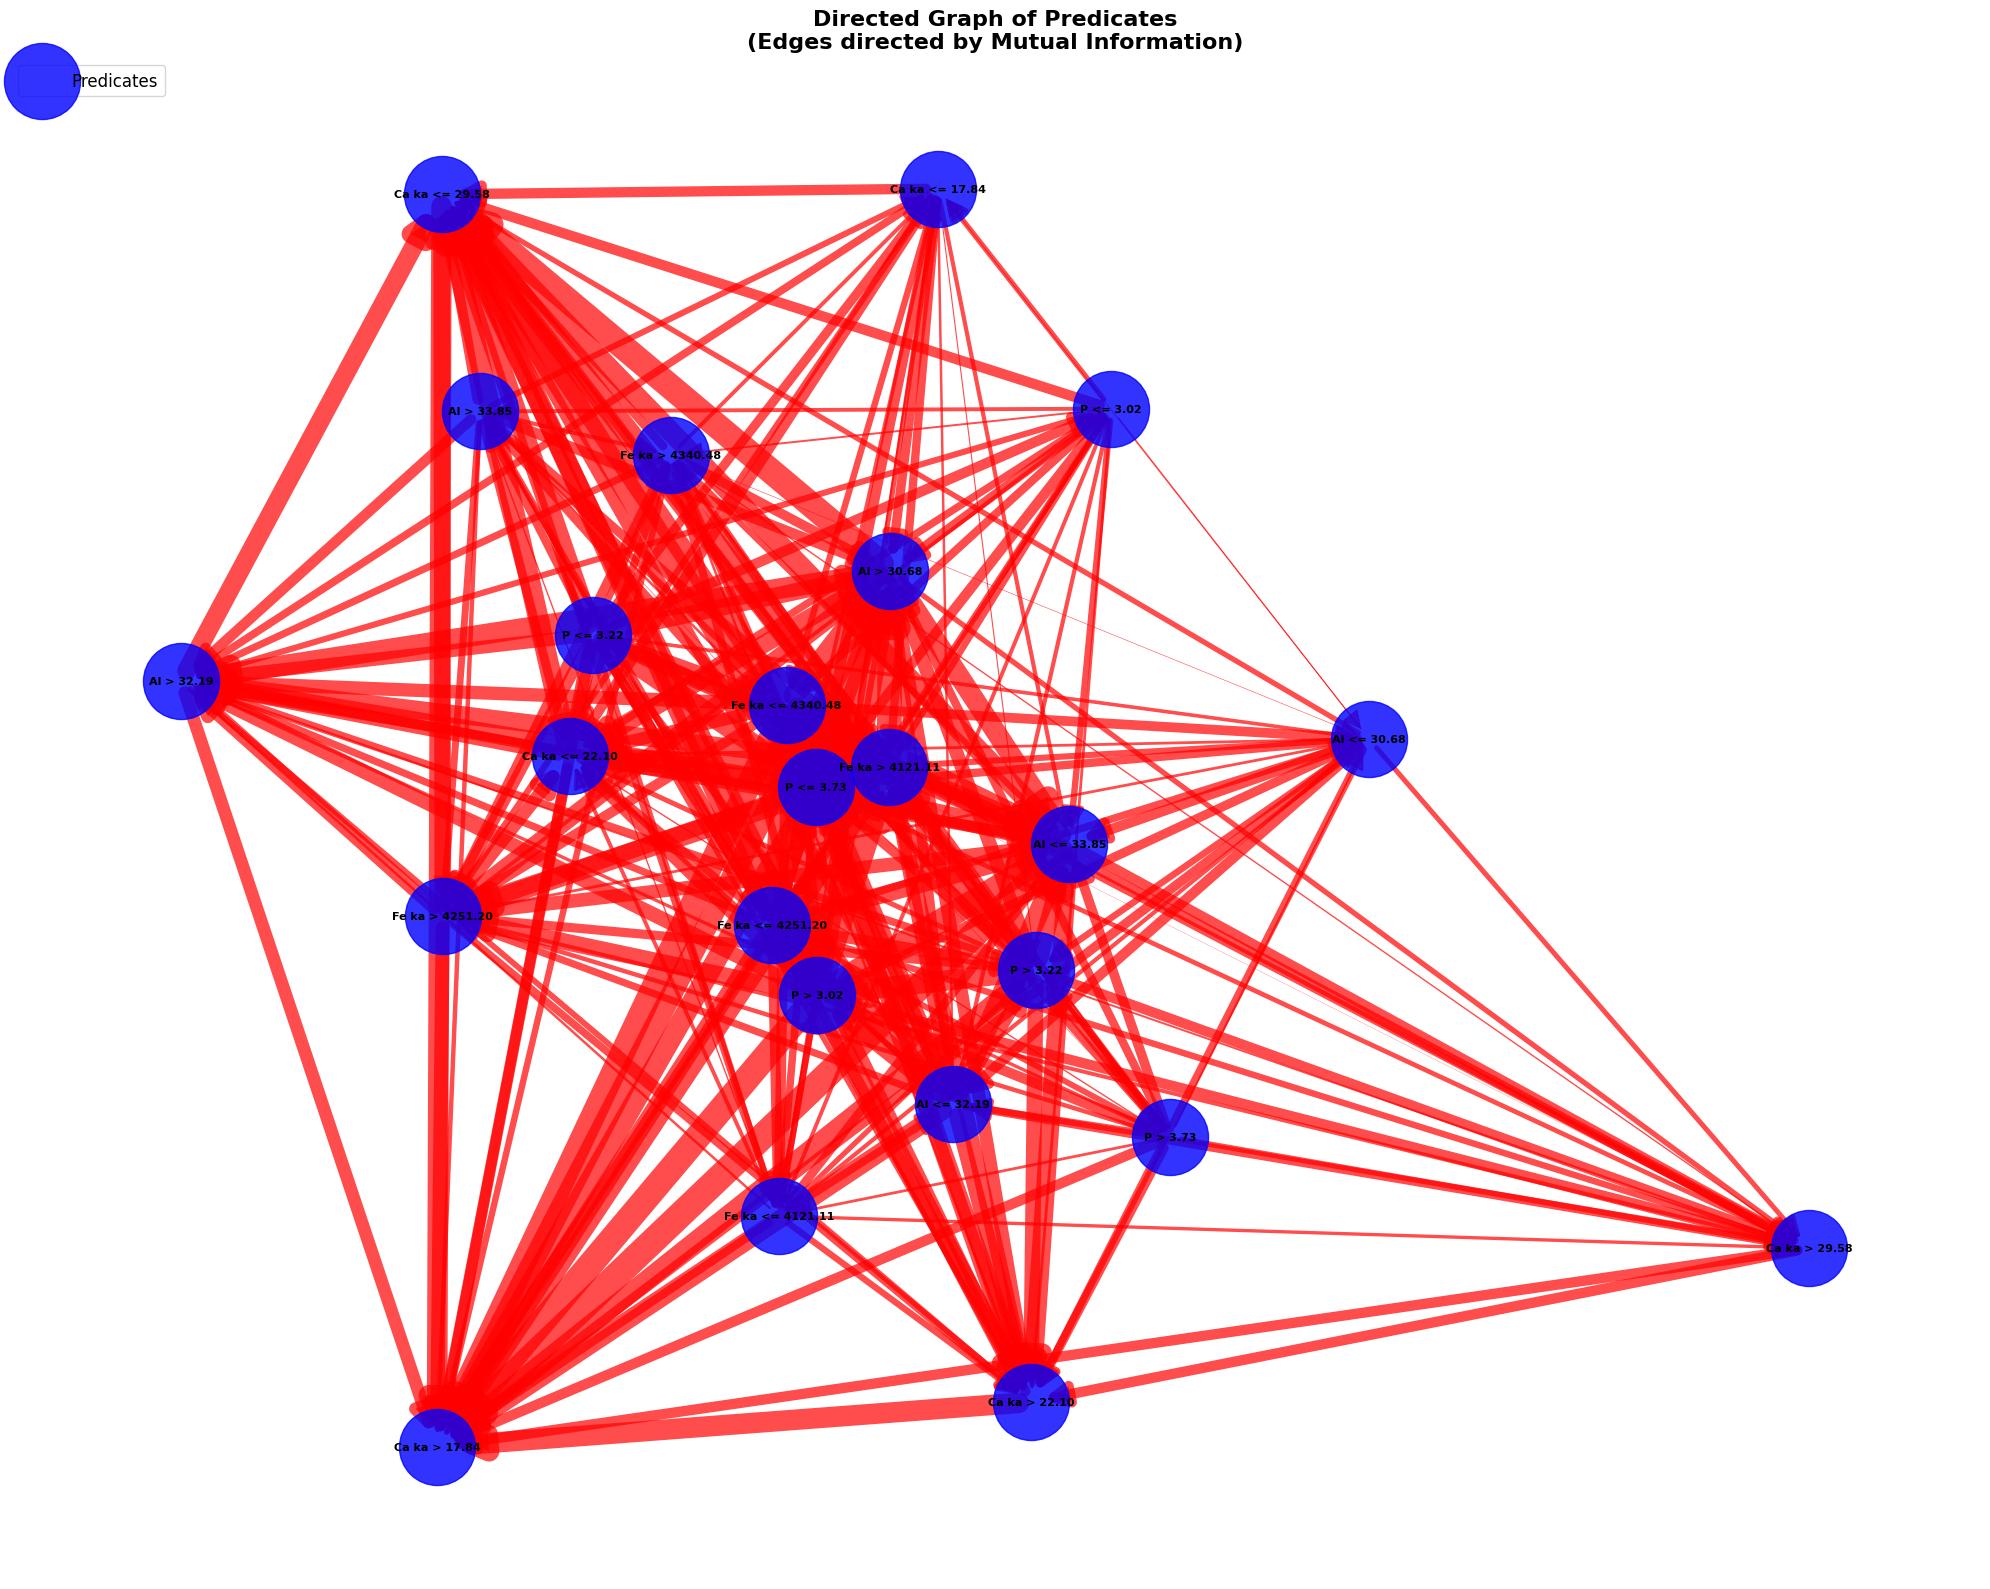

In [52]:
import matplotlib.pyplot as plt

# plotando o grafo direcionado
fig, ax = plt.subplots(figsize=(20, 16)) # criando a figura e o eixo
pos = nx.spring_layout(DG, k=2, iterations=50, seed=42) # layout de primavera para melhor espaçamento
# o draw_networkx_nodes e draw_networkx_edges desenham os nós e arestas do grafo
nx.draw_networkx_nodes(DG, pos, 
                       nodelist=predicados,
                       node_color='blue',
                       node_size=3000,
                       alpha=0.8,
                       label='Predicates')
# o draw_networkx_edges desenha as arestas do grafo
edge_weights = [DG[u][v]['weight']/5 for u, v in DG.edges()]  # Scale for visualization
nx.draw_networkx_edges(DG, pos, 
                       width=edge_weights,
                       edge_color='red',
                       alpha=0.7,
                       arrows=True,
                       arrowsize=30)
# o draw_networkx_labels desenha os rótulos dos nós
nx.draw_networkx_labels(DG, pos, font_size=8, font_weight='bold')
# adicionando título e legenda
plt.title('Directed Graph of Predicates\n(Edges directed by Mutual Information)',
            fontsize=16, fontweight='bold')
plt.legend(loc='upper left', fontsize=12)
plt.axis('off')
plt.tight_layout()
plt.show()

In [53]:
# calculando a local reach centrality para os nós do grafo direcionado DG levando em conta o peso das arestas
local_reach_centrality_weighted = {node: nx.local_reaching_centrality(DG, node, weight='weight') for node in DG.nodes()}
pd.Series(local_reach_centrality_weighted).sort_values(ascending=False)

P <= 3.22           1.080614
Fe ka <= 4251.20    1.008573
Fe ka <= 4340.48    0.882224
P <= 3.02           0.866708
P <= 3.73           0.852299
Al <= 32.19         0.821266
P > 3.22            0.810737
Al > 33.85          0.767328
P > 3.02            0.753659
Fe ka > 4121.11     0.710988
Fe ka <= 4121.11    0.698797
Al <= 30.68         0.671089
P > 3.73            0.655018
Ca ka <= 17.84      0.602003
Fe ka > 4340.48     0.582977
Al > 30.68          0.534211
Fe ka > 4251.20     0.466049
Al <= 33.85         0.342471
Ca ka <= 22.10      0.333051
Al > 32.19          0.156273
Ca ka > 29.58       0.123024
Ca ka > 22.10       0.123024
Ca ka <= 29.58      0.082016
Ca ka > 17.84       0.000000
dtype: float64

In [54]:
# vip scores plot for PLS-DA
plsda_results[4].T.plot() # VIP scores plot

In [55]:
# calculando betweenness centrality para os nós do grafo direcionado DG levando em conta o peso das arestas
betweenness_centrality_weighted = nx.betweenness_centrality(DG, weight='weight')
pd.Series(betweenness_centrality_weighted).sort_values(ascending=False)

Al <= 30.68         0.071146
Ca ka <= 17.84      0.070158
P > 3.73            0.030632
Ca ka > 29.58       0.016798
Fe ka > 4340.48     0.016140
Al > 32.19          0.013834
Fe ka <= 4121.11    0.012187
Ca ka <= 22.10      0.010540
Ca ka > 22.10       0.007905
Fe ka > 4251.20     0.005599
P > 3.22            0.004611
Al > 33.85          0.003953
Al > 30.68          0.000000
P <= 3.02           0.000000
Al <= 33.85         0.000000
Al <= 32.19         0.000000
P > 3.02            0.000000
Ca ka > 17.84       0.000000
P <= 3.22           0.000000
P <= 3.73           0.000000
Fe ka > 4121.11     0.000000
Ca ka <= 29.58      0.000000
Fe ka <= 4251.20    0.000000
Fe ka <= 4340.48    0.000000
dtype: float64

In [56]:
# calculando eigenvector centrality para os nós do grafo direcionado DG levando em conta o peso das arestas
eigenvector_centrality_weighted = nx.eigenvector_centrality(DG, max_iter=1000, weight='weight')
pd.Series(eigenvector_centrality_weighted).sort_values(ascending=False)

# o eigenvector centrality mede a influência de um nó na rede
# ele atribui pontuações mais altas a nós que estão conectados a outros nós influentes
# é útil para identificar predicados que são centrais na rede de regras
# ele é calculado extraindo os autovetores da matriz de adjacência do grafo
# os autovetores representam a importância relativa dos nós na rede

Ca ka > 17.84       9.999965e-01
Ca ka <= 29.58      2.628400e-03
Ca ka > 22.10       1.313949e-05
Ca ka > 29.58       6.121413e-08
Al > 32.19          1.407708e-09
Al <= 33.85         6.023631e-12
Ca ka <= 22.10      2.072329e-14
Al > 30.68          4.377020e-17
Fe ka > 4251.20     8.588593e-20
Fe ka > 4121.11     1.350843e-22
P > 3.02            1.644956e-25
P <= 3.73           2.181174e-28
Fe ka <= 4340.48    2.374680e-31
P > 3.22            3.183124e-34
Al <= 32.19         4.868657e-37
Ca ka <= 17.84      3.191695e-39
Al <= 30.68         5.819208e-41
Fe ka <= 4121.11    1.661946e-43
Fe ka > 4340.48     1.320424e-43
P > 3.73            6.486722e-46
Fe ka <= 4251.20    9.634576e-49
Al > 33.85          1.717370e-51
P <= 3.02           1.885201e-54
P <= 3.22           3.888617e-58
dtype: float64

# **Exemplo para entender o netowrkX**

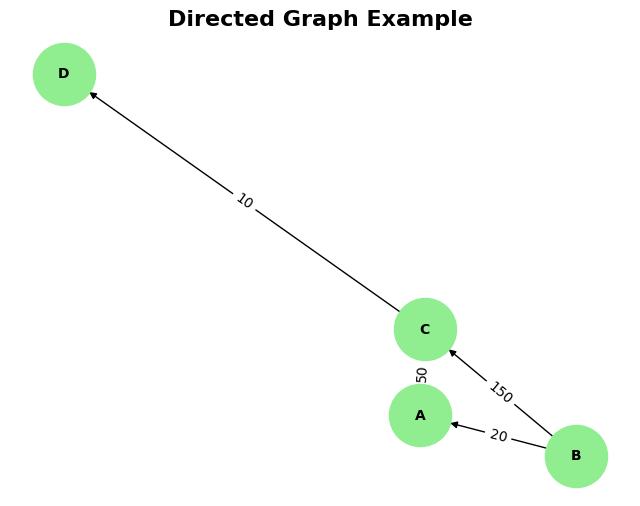

In [57]:
DG = nx.DiGraph()
DG.add_node("A")
DG.add_node("B")
DG.add_node("C")
DG.add_node("D")
DG.add_edge("B", "A", weight=20)
DG.add_edge("B", "C", weight=150)
DG.add_edge("A", "C", weight=50)
DG.add_edge("C", "D", weight=10)
 #plotar o grafo direcionado
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
pos = nx.spring_layout(DG, seed=42)
nx.draw(DG, pos, with_labels=True, node_color='lightgreen', node_size=2000, font_size=10, font_weight='bold', arrows=True)
edge_labels = nx.get_edge_attributes(DG, 'weight')
nx.draw_networkx_edge_labels(DG, pos, edge_labels=edge_labels)
plt.title('Directed Graph Example', fontsize=16, fontweight='bold')
plt.show()

In [58]:
# calculando a local reach centrality para os nós do grafo direcionado DG levando em conta o peso das arestas
local_reach_centrality_weighted = {node: nx.local_reaching_centrality(DG, node, weight='weight') for node in DG.nodes()}
pd.Series(local_reach_centrality_weighted).sort_values(ascending=False)

B    1.449275
A    0.463768
C    0.057971
D    0.000000
dtype: float64